# Formulation
### Solution form

Solution will be in the form of graph vertex vectors arranged in the order of visiting, assigned to individual drones<br>

<center>
$d_{1}=(1,3,5...)$<br>
$d_{2}=(2,7,9...)$<br>
&emsp;&emsp;.<br>
&emsp;&emsp;.<br>
&emsp;&emsp;.<br>
$d_{M}=(10,15,4...)$<br>
   </center>
M - number of paths

### Cost function

\begin{equation*}
F=min (\sum \limits _{v=1} ^{M} \sum \limits _{i=0} ^{N} \sum \limits _{j=0} ^{N} c_{ij} x_{vij})
\end{equation*}

where:
<ul>
    <li>$M$ – number of paths
    <li>$N$ – number of receivers
    <li>$c_{ij}$ – cost of travelling from receiver $i$ to $j$
    <li>$x_vij$ – decision variable that determines whether the $v$ drone is routing from $i$ to $j$
    <li>$x_{vij} = \left\{
            \begin{array}{ll}
                1 & \mbox{when the drone is heading from i to j}\\
                0 & \mbox{otherwise}
            \end{array}
        \right. 
        $
</ul>                  

### Constraints
If $ x_{vij} = 1 \Rightarrow  u_{i} + q_{vj} = u_{j}$</br>

<center>$ q_{vi} \leq u_{i} \leq Q \quad \forall_{i} \in_{1, 2,..., N} $</center>

<!-- \begin{equation*}
\sum \limits _{v=1} ^{M} \sum \limits _{i=0} ^{N} y_{iv} \leq Q
\end{equation*}
\begin{equation*}
\sum \limits _{i=0} ^{N} y_{iv} \leq Q \quad }
\end{equation*}
 -->
$ q_{vi} $ – the amount of demand delivered to $i$-th client by $v$-th drone

$Q$ – drone capacity


### Data structures

> Distance matrix

\begin{equation*}
M_{i,j} = 
\begin{pmatrix}
d_{1,1} & d_{1,2} & \cdots & d_{1,n} \\
d_{2,1} & d_{2,2} & \cdots & d_{2,n} \\
\vdots  & \vdots  & \ddots & \vdots  \\
d_{i,1} & d_{i,2} & \cdots & d_{i,j} 
\end{pmatrix}
\end{equation*}

where:
<ul>
    <li>$i, j$ - identifiers of each receiver</li>
    <li>$d_{i,j}$ - distance between reveivers $i, j$</li>
    <li>distance - euclidian distance $d_{i,j} = \sqrt{(x_{i}-x_{j})^{2}+(y_{i}-y_{j})^{2}}$
</ul>

> List of positions for each receiver

<center>$ L_{i} = a_{1}, a_{2},... a_{i} $</center>

where:
<ul>
    <li>$a_{i}$ - coordinates of $i - th$ receiver $(x_{i}, y_{i})$</li>
</ul>

<h2>Imports</h2>

In [13]:
from tabu_search import TabuSearch
from visualization import WithVisualization
from matplotlib import pyplot as plt
import numpy as np

<h2>Testing algorithm parameters</h2>

In [14]:
# Constants - change for testing
MAX_COST = 99999
MIN_TABU_SIZE = 50
MAX_TABU_SIZE = 52
TABU_STEP = 1
NUM_OF_TESTS = 3
N_ITERS = 5000
FILE_NAME = "test_data.txt"
NUM_DRONES = 8
DRONE_CAPACITY = 4
NUM_CLIENTS = 30

# Structures for storing history
best_of_all = MAX_COST
size = MIN_TABU_SIZE
costs_history = []
best_costs_history = []
fitness_history = []
tabu_size_average_costs = {}
best_model_result = None
best_tabu_size = None

# Main loop for testing parameters
while size <= MAX_TABU_SIZE:
    for _ in range(NUM_OF_TESTS):
        ts = TabuSearch(NUM_DRONES, DRONE_CAPACITY, NUM_CLIENTS, FILE_NAME)
        ts.search(tabu_size=size, n_iters=N_ITERS)
        best_cost = ts._fitness(ts.best_solution)
        print(f'Tabu size: {size}, Best_cost: {best_cost}')
        fitness_history.append(ts.best_cost)
        best_costs_history.append(ts.best_costs)
        costs_history.append(ts.costs)
        if best_cost < best_of_all:
            best_of_all = best_cost
            best_tabu_size = size
            best_model_result = ts
    hist_arr = np.array(fitness_history)
    tabu_size_average_costs[size] = hist_arr.mean()
    fitness_history = []
    print('=========================')
    print(f'Average: {tabu_size_average_costs[size]}')
    print(f'Best: {hist_arr.min()}\n')
    size += TABU_STEP
print(f"BEST COST: {best_of_all} | TABU SIZE: {best_tabu_size} | NUM OF ITERS: {N_ITERS}")

Elapsed time 4.965731382369995 s
Tabu size: 50, Best_cost: 535.4680340793713
Elapsed time 4.947450876235962 s
Tabu size: 50, Best_cost: 537.402266500873
Elapsed time 4.929550647735596 s
Tabu size: 50, Best_cost: 535.4680340793713
Average: 536.1127782198719
Best: 535.4680340793713

Elapsed time 4.937871694564819 s
Tabu size: 51, Best_cost: 535.4680340793713
Elapsed time 4.881753444671631 s
Tabu size: 51, Best_cost: 535.4680340793713
Elapsed time 4.886321067810059 s
Tabu size: 51, Best_cost: 535.4680340793713
Average: 535.4680340793713
Best: 535.4680340793713

Elapsed time 4.984978437423706 s
Tabu size: 52, Best_cost: 535.4680340793713
Elapsed time 4.847826957702637 s
Tabu size: 52, Best_cost: 535.4680340793713
Elapsed time 4.874605178833008 s
Tabu size: 52, Best_cost: 535.4680340793713
Average: 535.4680340793713
Best: 535.4680340793713

BEST COST: 535.4680340793713 | TABU SIZE: 50 | NUM OF ITERS: 5000


In [15]:
# Run this if figure outside of notebook
%matplotlib inline

<h2>Ploting test results</h2>

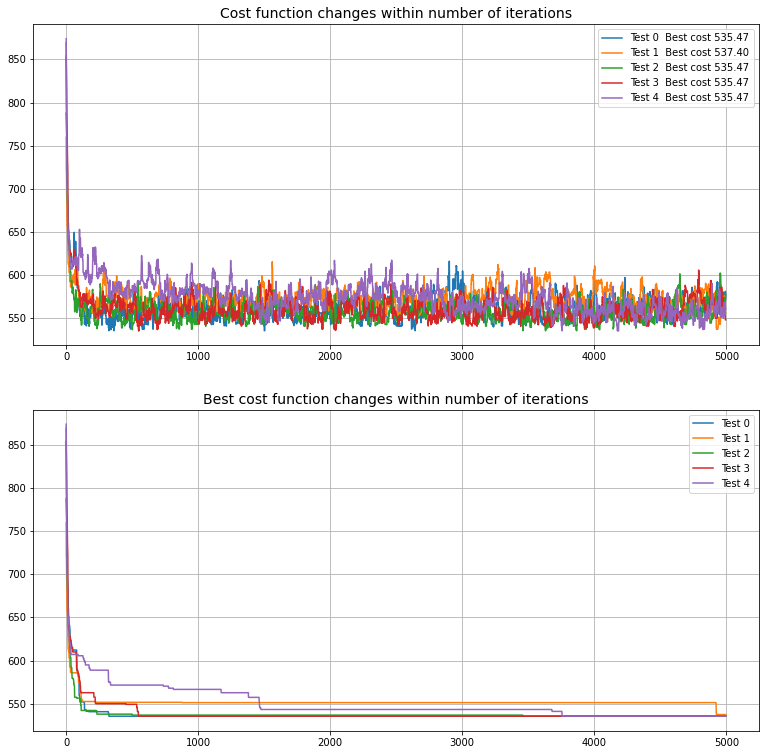

In [19]:
# Plot cost function history for each test
# NOTE: number of test is reduced by slicing 
#       for better illustration
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 13))
for i, (c, b) in enumerate(zip(costs_history[0:5], best_costs_history[0:5])):
    ax1.plot(c[5:], label=f'Test {i}  Best cost {min(b):.2f}')
    ax2.plot(b[5:], label=f'Test {i}')
ax2.legend(), ax1.legend()
ax1.grid(), ax2.grid()
ax1.set_title("Cost function changes within number of iterations", fontdict={'fontsize': 14})
ax2.set_title("Best cost function changes within number of iterations", fontdict={'fontsize': 14})
plt.show()

<h2>Ploting best result</h2>

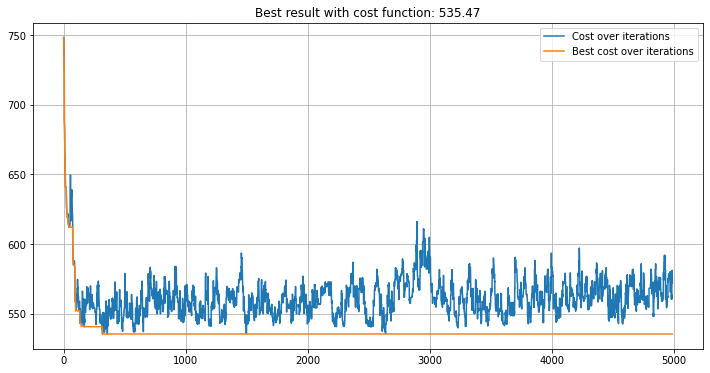

In [17]:
# Plot best solution cost history
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(best_model_result.costs[10:], label="Cost over iterations")
ax.plot(best_model_result.best_costs[10:], label="Best cost over iterations")
ax.set_title(f"Best result with cost function: {best_of_all:.2f}")
ax.legend()
plt.grid()
plt.show()

## Visualization of best solution

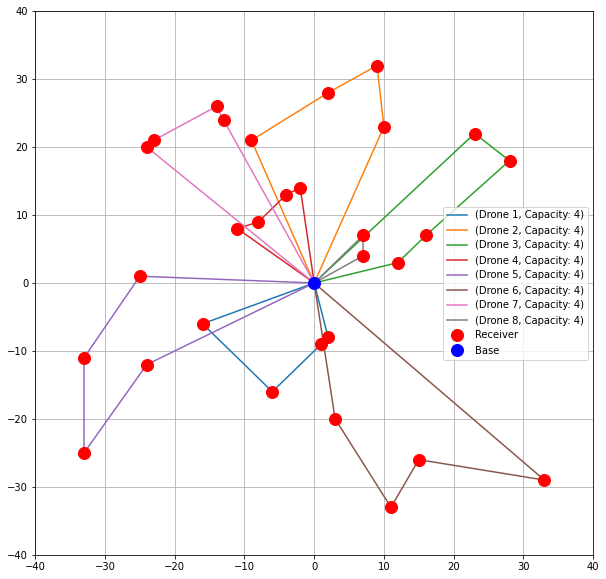

In [18]:
vis = WithVisualization(best_model_result)
vis.plot_figure(sizes=(10, 10))
vis.plot_solution()

In [7]:
# Run this if figure outside of nobebook
# necessary for live visualization
%matplotlib qt

## Live visualization

In [8]:
# Logs clear
logs = open("logs.txt", "w")
logs.close()

vis = WithVisualization(best_model_result)
vis.visualize_solution()